# GraphPipeline

GraphPipelines (`tpot2.GraphPipeline`) work similarly to the scikit-learn Pipeline class. Rather than provide a list of steps, in GraphPipeline you provide a directed acyclic graph (`networkx.DiGraph`) of steps using networkx. In GraphPipeline, parents get their inputs from their children (i.e the leafs get the raw inputs (X,y), and the roots are the final classifiers/regressors). 

The label of the nodes can be anything, but must unique per instance of an sklearn estimator. Each node has an attribute called "instance" for the instance of the scikit-learn estimator.

GraphPipeline allows for classifiers and regressors in the middle of the pipeline. In this case, GraphPipeline will will try to use the outputs of predict_proba, decision_function, or predict in that order. If cross_val_predict_cv is set, the downstream models are trained with the output of `sklearn.model_selection.cross_val_predict` (final results are predicted using the models trained on the full data).


    Parameters
    ----------

    graph: networkx.DiGraph
        A directed graph where the nodes are sklearn estimators and the edges are the inputs to those estimators.
    
    cross_val_predict_cv: int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy used in inner classifiers or regressors

    method: str, optional
        The prediction method to use for the inner classifiers or regressors. If 'auto', it will try to use predict_proba, decision_function, or predict in that order.

    memory: str or object with the joblib.Memory interface, optional
        Used to cache the input and outputs of nodes to prevent refitting or computationally heavy transformations. By default, no caching is performed. If a string is given, it is the path to the caching directory.

    use_label_encoder: bool, optional
        If True, the label encoder is used to encode the labels to be 0 to N. If False, the label encoder is not used.
        Mainly useful for classifiers (XGBoost) that require labels to be ints from 0 to N.

        Can also be a sklearn.preprocessing.LabelEncoder object. If so, that label encoder is used.

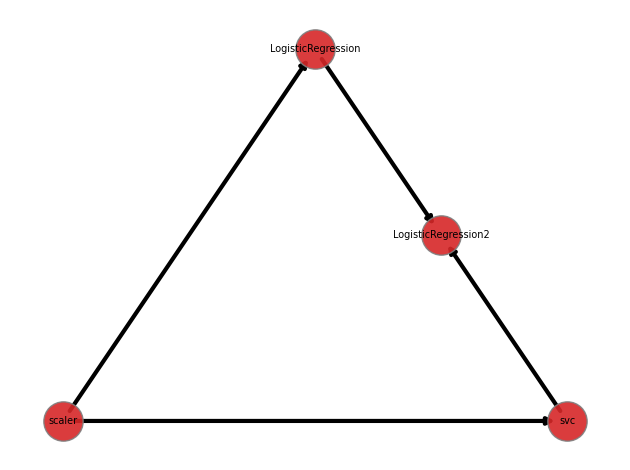

score
0.8974358974358974


In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import networkx as nx
from tpot2 import GraphPipeline
import sklearn.metrics

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)


g = nx.DiGraph()

g.add_node("scaler", instance=StandardScaler())
g.add_node("svc", instance=SVC())
g.add_node("LogisticRegression", instance=LogisticRegression())
g.add_node("LogisticRegression2", instance=LogisticRegression())

g.add_edge("svc","scaler")
g.add_edge("LogisticRegression", "scaler")
g.add_edge("LogisticRegression2", "LogisticRegression")
g.add_edge("LogisticRegression2", "svc")


est = GraphPipeline(g)
est.plot()
est.fit(X_train, y_train)
print("score")
print(sklearn.metrics.roc_auc_score(y_test, est.predict_proba(X_test)[:,1]))

### Cross val predict

Using cross_val_predict_cv can improve performance in some cases. 

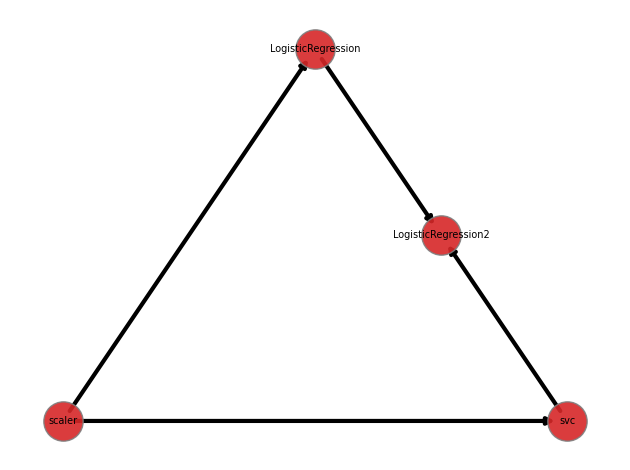

score
0.9166666666666666


In [6]:
est = GraphPipeline(g, cross_val_predict_cv=10)
est.plot()
est.fit(X_train, y_train)
print("score")
print(sklearn.metrics.roc_auc_score(y_test, est.predict_proba(X_test)[:,1]))

You can access individual steps of a GraphPipeline using the label of each node.

In [7]:
svc = est.graph.nodes["svc"]["instance"]
svc

SVC()